# PathMNIST Classification RF & AdaBoost
This notebook demonstrates subsampling, balancing, PCA, and compares Random Forest vs AdaBoost classifiers on the PathMNIST dataset.

In [1]:
!pip install scikit-learn imbalanced-learn medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

## 1. Configuration

In [ ]:
params = {"random_state": 42, "subsample_size": 10000, "pca_variance": 0.95}

## 2. Data Loading

In [ ]:
from medmnist import PathMNIST


def load_data(split, normalize=True):
    ds = PathMNIST(split=split, download=(split == "train"))
    X = ds.imgs.reshape(-1, 28 * 28 * 3).astype(float)
    if normalize:
        X /= 255.0
    return X, ds.labels.flatten()


X_train, y_train = load_data("train")
X_test, y_test = load_data("test")

100%|██████████| 206M/206M [00:09<00:00, 20.8MB/s]


## 3. Subsample & Balance

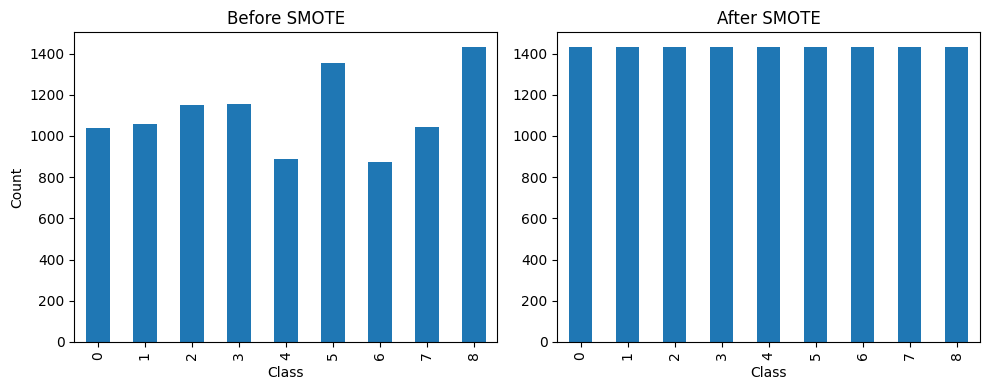

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

sss = StratifiedShuffleSplit(
    n_splits=1, train_size=params["subsample_size"], random_state=params["random_state"]
)
idx, _ = next(sss.split(X_train, y_train))
X_sub, y_sub = X_train[idx], y_train[idx]
X_bal, y_bal = SMOTE(random_state=params["random_state"]).fit_resample(X_sub, y_sub)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pd.Series(y_sub).value_counts().sort_index().plot.bar(ax=axes[0])
axes[0].set(title="Before SMOTE", xlabel="Class", ylabel="Count")
pd.Series(y_bal).value_counts().sort_index().plot.bar(ax=axes[1])
axes[1].set(title="After SMOTE", xlabel="Class")
plt.tight_layout()
plt.show()

## 4. PCA Scree Plot

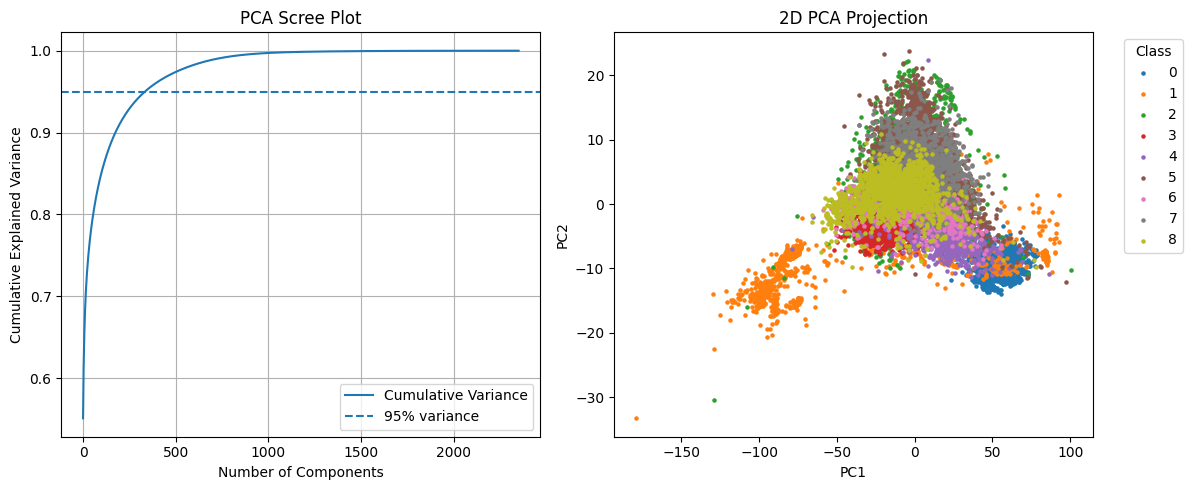

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler().fit(X_sub)
X_scaled = scaler.transform(X_sub)

pca_full = PCA().fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

pca2 = PCA(n_components=2).fit(X_scaled)
proj = pca2.transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(cum_var, label="Cumulative Variance")
axes[0].axhline(
    params["pca_variance"],
    linestyle="--",
    label=f"{int(params['pca_variance'] * 100)}% variance",
)
axes[0].set_xlabel("Number of Components")
axes[0].set_ylabel("Cumulative Explained Variance")
axes[0].set_title("PCA Scree Plot")
axes[0].legend()
axes[0].grid(True)

for cls in np.unique(y_sub):
    axes[1].scatter(proj[y_sub == cls, 0], proj[y_sub == cls, 1], s=5, label=str(cls))
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("2D PCA Projection")
axes[1].legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()
plt.show()

## 5. Model Comparison

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest (tuned) Accuracy: 0.7227

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1338
           1       0.95      0.99      0.97       847
           2       0.30      0.24      0.27       339
           3       0.85      0.90      0.87       634
           4       0.92      0.74      0.82      1035
           5       0.48      0.57      0.52       592
           6       0.53      0.39      0.45       741
           7       0.39      0.28      0.32       421
           8       0.61      0.72      0.66      1233

    accuracy                           0.72      7180
   macro avg       0.65      0.64      0.64      7180
weighted avg       0.72      0.72      0.71      7180



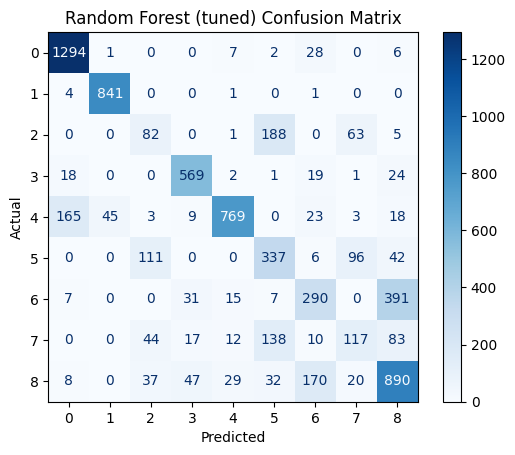

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


def evaluate(name, model, X, y):
    preds = model.predict(X)
    print(f"{name} Accuracy: {accuracy_score(y, preds):.4f}\n")
    print(classification_report(y, preds, zero_division=0))
    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=params["random_state"])

rf_pipe = Pipeline(
    [
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=params["pca_variance"])),
        (
            "rf",
            RandomForestClassifier(
                random_state=params["random_state"], n_jobs=-1, class_weight="balanced"
            ),
        ),
    ]
)

rf_params = {
    "rf__n_estimators": [100, 200, 300, 500],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__max_features": ["sqrt", "log2"],
    "rf__min_samples_split": [2, 5, 10],
}

search_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_params,
    n_iter=20,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    random_state=params["random_state"],
)
search_rf.fit(X_bal, y_bal)
best_rf = search_rf.best_estimator_

evaluate("Random Forest (tuned)", best_rf, X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
AdaBoost (tuned) Accuracy: 0.6086

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1338
           1       0.86      0.99      0.92       847
           2       0.22      0.27      0.24       339
           3       0.43      0.11      0.17       634
           4       0.77      0.87      0.82      1035
           5       0.32      0.26      0.29       592
           6       0.25      0.32      0.28       741
           7       0.36      0.45      0.40       421
           8       0.59      0.66      0.62      1233

    accuracy                           0.61      7180
   macro avg       0.53      0.53      0.51      7180
weighted avg       0.61      0.61      0.60      7180



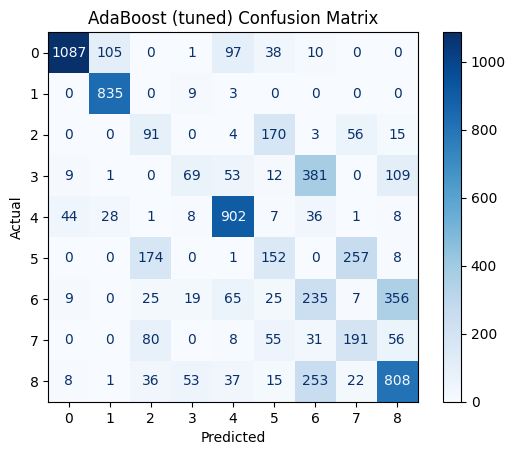

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ab_pipe = Pipeline(
    [
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=params["pca_variance"])),
        ("ab", AdaBoostClassifier(random_state=params["random_state"])),
    ]
)

ab_params = {
    "ab__n_estimators": [50, 100, 150, 200],
    "ab__learning_rate": [0.5, 1.0, 1.5],
}

search_ab = RandomizedSearchCV(
    ab_pipe,
    param_distributions=ab_params,
    n_iter=12,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    random_state=params["random_state"],
    error_score="raise",
)
search_ab.fit(X_bal, y_bal)
best_ab = search_ab.best_estimator_

evaluate("AdaBoost (tuned)", best_ab, X_test, y_test)